In [1]:
1

1

In [5]:
2

2

In [2]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle
import matplotlib.pyplot as plt
import math



In [3]:
output_dir = "../output/tests"
os.listdir(output_dir)

['J-10_Q-01_order1.h5',
 'J-10_Q-01_order2.h5',
 'J-12_Q-01_order1.h5',
 'J-12_Q-01_order2.h5',
 'J-14_Q-01_order2.h5',
 'J-14_Q-01_order1.h5',
 'J-08_Q-01_order2.h5',
 'J-06_Q-01_order1.h5',
 'J-08_Q-01_order1.h5']

In [4]:
J=[6,8,10,12,14]
order = [1,2]
Q=1

In [7]:
def create_model_adjustable(J,Q,order,k_size,nchan_out,activation):
	N = 2**15
	y = np.random.rand(N)
	scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
	Sy = np.array(scattering(torch.Tensor(y))).T
	input_x,input_y = Sy.shape
	nchan_in = 1       # number of input channels.  1 since it is BW

	input_shape = (input_x,input_y)#Sy.shape
	kernel_size = (k_size,)
	K.clear_session()
	model=Sequential()
	#1 conv layer +  1 batch normalization + nonlinear activation + pooling
	model.add(BatchNormalization(input_shape=input_shape))
	model.add(Conv1D(filters=nchan_out,
		kernel_size=kernel_size, padding="same",name='conv1'))
	#model.add(BatchNormalization())
	model.add(Activation("relu"))

	if model.layers[-1].output_shape[1]>=4:
		pool = 4
	elif model.layers[-1].output_shape[1]==2:
		pool = 2
	    
	model.add(AveragePooling1D(pool_size=(pool,)))


	for i in range(3):
		model.add(Conv1D(filters=nchan_out,
		             kernel_size=kernel_size, padding="same" ))
		model.add(BatchNormalization())
		model.add(Activation("relu"))
		#print('before pool',model.layers[-1].output_shape)
		if model.layers[-1].output_shape[1] >= 4:
			model.add(AveragePooling1D(pool_size=(4,)))
		elif model.layers[-1].output_shape[1] == 2:
			model.add(AveragePooling1D(pool_size=(2,)))
		#print(model.layers[-1].output_shape)

	model.add(BatchNormalization())
	model.add(Flatten())
	model.add(Dense(64, activation='relu'))
	model.add(BatchNormalization())
	#what activation should be chosen for last layer, for regression problem? should be a linear function
	model.add(Dense(5, activation=activation)) #output layer that corresponds to the 5 physical parameters.


	# Compile the model
	model.compile(loss='mse', optimizer='adam', metrics=['mse'])




	return model

In [16]:
pkl_dir = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/'
record = []
for j in J:
    for o in order:
        if j==6 and o==2:
            pass
        else:
            model_path = os.path.join(
               output_dir, "_".join([ "J-" + str(j).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(o)]) + ".h5")
            print(model_path)
            model = create_model_adjustable(j,Q,o,k_size=8,nchan_out=16,activation='linear')
            model.load_weights(model_path)
            #load test and train files
            pickle_name = "_".join(
                ["scattering",
                "J-" + str(j).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(o)]
            )
            pkl_path_test = os.path.join(pkl_dir,pickle_name+"_fold-test.pkl")
            pkl_test = open(pkl_path_test,'rb')
            Sy_test,y_test = pickle.load(pkl_test)
            pkl_path_train = os.path.join(pkl_dir,pickle_name+"_fold-train.pkl")
            pkl_train = open(pkl_path_train, 'rb')
            Sy_train,y_train = pickle.load(pkl_train)

            for idx in range(2,4):
                y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
                y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]

            scaler = MinMaxScaler()
            scaler.fit(y_train)
            y_test_normalized = scaler.transform(y_test)
            #log scale the input
            eps = 1e-11
            Sy_test_log2 = np.log1p((Sy_test>0)*Sy_test/eps)
            print("start evaluating")
            hist = model.evaluate(Sy_test_log2,y_test_normalized)
            record.append((j,o,hist[0]))
        

../output/tests/J-06_Q-01_order1.h5
start evaluating
10000/10000 [==============================] - 1s 144us/sample - loss: 0.0519 - mean_squared_error: 0.0519
../output/tests/J-08_Q-01_order1.h5
start evaluating
10000/10000 [==============================] - 1s 145us/sample - loss: 0.0521 - mean_squared_error: 0.0521
../output/tests/J-08_Q-01_order2.h5
start evaluating
10000/10000 [==============================] - 2s 167us/sample - loss: 0.0458 - mean_squared_error: 0.0458
../output/tests/J-10_Q-01_order1.h5
start evaluating
10000/10000 [==============================] - 1s 140us/sample - loss: 0.0675 - mean_squared_error: 0.0675
../output/tests/J-10_Q-01_order2.h5
start evaluating
10000/10000 [==============================] - 1s 140us/sample - loss: 0.0377 - mean_squared_error: 0.0377
../output/tests/J-12_Q-01_order1.h5
start evaluating
10000/10000 [==============================] - 1s 130us/sample - loss: 0.0483 - mean_squared_error: 0.0483
../output/tests/J-12_Q-01_order2.h5
star

manually fit J-6, order=2


In [17]:
record

[(6, 1, 0.05194204691052437),
 (8, 1, 0.052052471125125885),
 (8, 2, 0.045803333097696304),
 (10, 1, 0.06753752752542495),
 (10, 2, 0.03771992841362953),
 (12, 1, 0.0483383327126503),
 (12, 2, 0.036508769923448564),
 (14, 1, 0.0500540704369545),
 (14, 2, 0.03513952844142914)]

In [18]:
order1 = []
j1 = []
order2 = []
j2= []
for j,o,score in record:
    if o==1:
        order1.append(score)
        j1.append(j)
    elif o==2:
        order2.append(score)
        j2.append(j)
    

(0.0, 0.1)

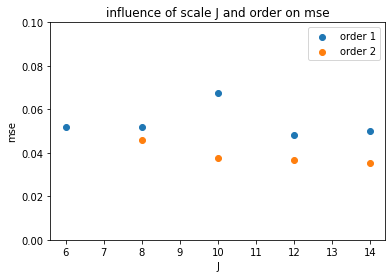

In [38]:
plt.scatter(j1,order1)
plt.scatter(j2,order2)
plt.legend(['order 1', 'order 2'])
plt.xlabel('J')
plt.ylabel('mse')
plt.title('influence of scale J and order on mse')
plt.ylim([0,0.1])